In [34]:
from IPython.display import display, clear_output
import keyboard
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ['cmr10'],
    "axes.labelsize": 22, 
    "axes.titlesize": 25, 
    "xtick.labelsize": 22, 
    "ytick.labelsize": 22, 
    "legend.fontsize": 20,
    "figure.figsize": [12, 7], 
    "figure.dpi": 300 
})

#### Define t($\omega$): 
$$t(\omega)=\frac{-\kappa}{(\Omega-\omega)-i\kappa-i\frac{g^2}{i(\Delta E-\omega)+\gamma}}$$

In [35]:
def t_w (w, k, Omega, DeltaE, gamma, g):
    up = -k
    down = (Omega-w) - 1j * k - 1j * g**2 / (1j * (DeltaE - w) + gamma)
    t = up / down
    return abs(t)

 # NO noise

## Creamos base de datos

In [36]:
# Definimos una función que genere la base de datos
def Parameters_generator (num_datos):
    k = np.random.uniform(1e-4, 1e-2, num_datos)
    DeltaE = np.random.uniform(0.5, 1.5, num_datos)
    gamma = np.random.uniform(1e-4, 1e-2, num_datos)
    g = np.random.uniform(1e-4, 1e-2, num_datos)

    return k, DeltaE, gamma, g

num_datos = 10000

In [37]:
# #Creamos base de datos y guardamos en .txt
# k, DeltaE, gamma, g = Parameters_generator (num_datos)
# np.savetxt('Parameters_previous-set.txt', np.column_stack((k, DeltaE, gamma, g)),
#             header='\u03BA \u0394E \u213D g',  encoding='utf-8') 

In [38]:
datos = np.loadtxt('Parameters_previous-set.txt', skiprows=0)
k = datos[:,0]
DeltaE = datos[:,1]
gamma = datos[:,2]
g = datos[:,3]
Omega = 1

#Creamos los valores de y (la función t(w)) con nuestra base de datos
w_values = np.linspace(0.85, 1.15, 300)

# Crear una matriz para almacenar los t(w)
t_values = np.zeros((num_datos, len(w_values)))

# Almacenar los resultados en la matriz 
# (elemento [i,j] fila i es el número de combinación de [k, DeltaE, gamma, g] 
# y la comluna j el elemento de w_values)
for i in range (num_datos):
    t_values[i,:] = t_w(w_values, k[i], Omega, DeltaE[i], gamma[i], g[i])


## Red neuronal

### Tensorflow/Keras

In [39]:
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.constraints import NonNeg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import pickle

#### Preparamos datos e hiperparámetros

In [40]:
#Seleccionamos los datos de entrenamiento y de validación
x_train, x_post, y_train, y_post = train_test_split(t_values, datos, test_size=0.2) # si añades random_state= 
                                                                        # tienes siempre la misma combinación
x_val, x_test, y_val, y_test = train_test_split(x_post, y_post, test_size=0.5)

# Normalizamos los datos
scaler_x = RobustScaler()
x_train_norm = scaler_x.fit_transform(x_train)
x_val_norm = scaler_x.transform(x_val)
x_test_norm = scaler_x.transform(x_test)

scaler_y = RobustScaler()
y_train_norm = scaler_y.fit_transform(y_train)
y_val_norm = scaler_y.transform(y_val)
y_test_norm = scaler_y.transform(y_test)

# Comprobamos las dimensiones de nuestros datos
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'validation samples')
print(x_test.shape[0], 'test samples')
print("x_train shape",x_train.shape)
print("y_train shape",y_train.shape)

#Número de neuronas de entrada y salida, y de la capa oculta
input_neurons  = x_train.shape[1]
output_neurons = y_train.shape[1]

#Elegimos los hiperparámetros
batch_size = 250
epochs = 1000
optimizer = Adam()


8000 train samples
1000 validation samples
1000 test samples
x_train shape (8000, 300)
y_train shape (8000, 4)


#### Definimos modelo

In [41]:
def Dense_five ():
    model = Sequential()
    model.add(Input(shape=(input_neurons,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32 , activation='relu'))
    model.add(Dense(16 , activation='relu'))
    model.add(Dense(output_neurons, activation='linear', kernel_constraint=NonNeg())) 

    #Compila el modelo
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

 #### Entrenamos

In [42]:
# model =  Dense_five()

# # Fiteamos el modelo
# history = model.fit(x_train_norm, y_train_norm, batch_size=batch_size, validation_data=(x_val_norm, y_val_norm),
#                     epochs=epochs, verbose=2)

# # Guardar el history en un archivo .pkl
# with open('model_history.pkl', 'wb') as file:
#     pickle.dump(history.history, file)

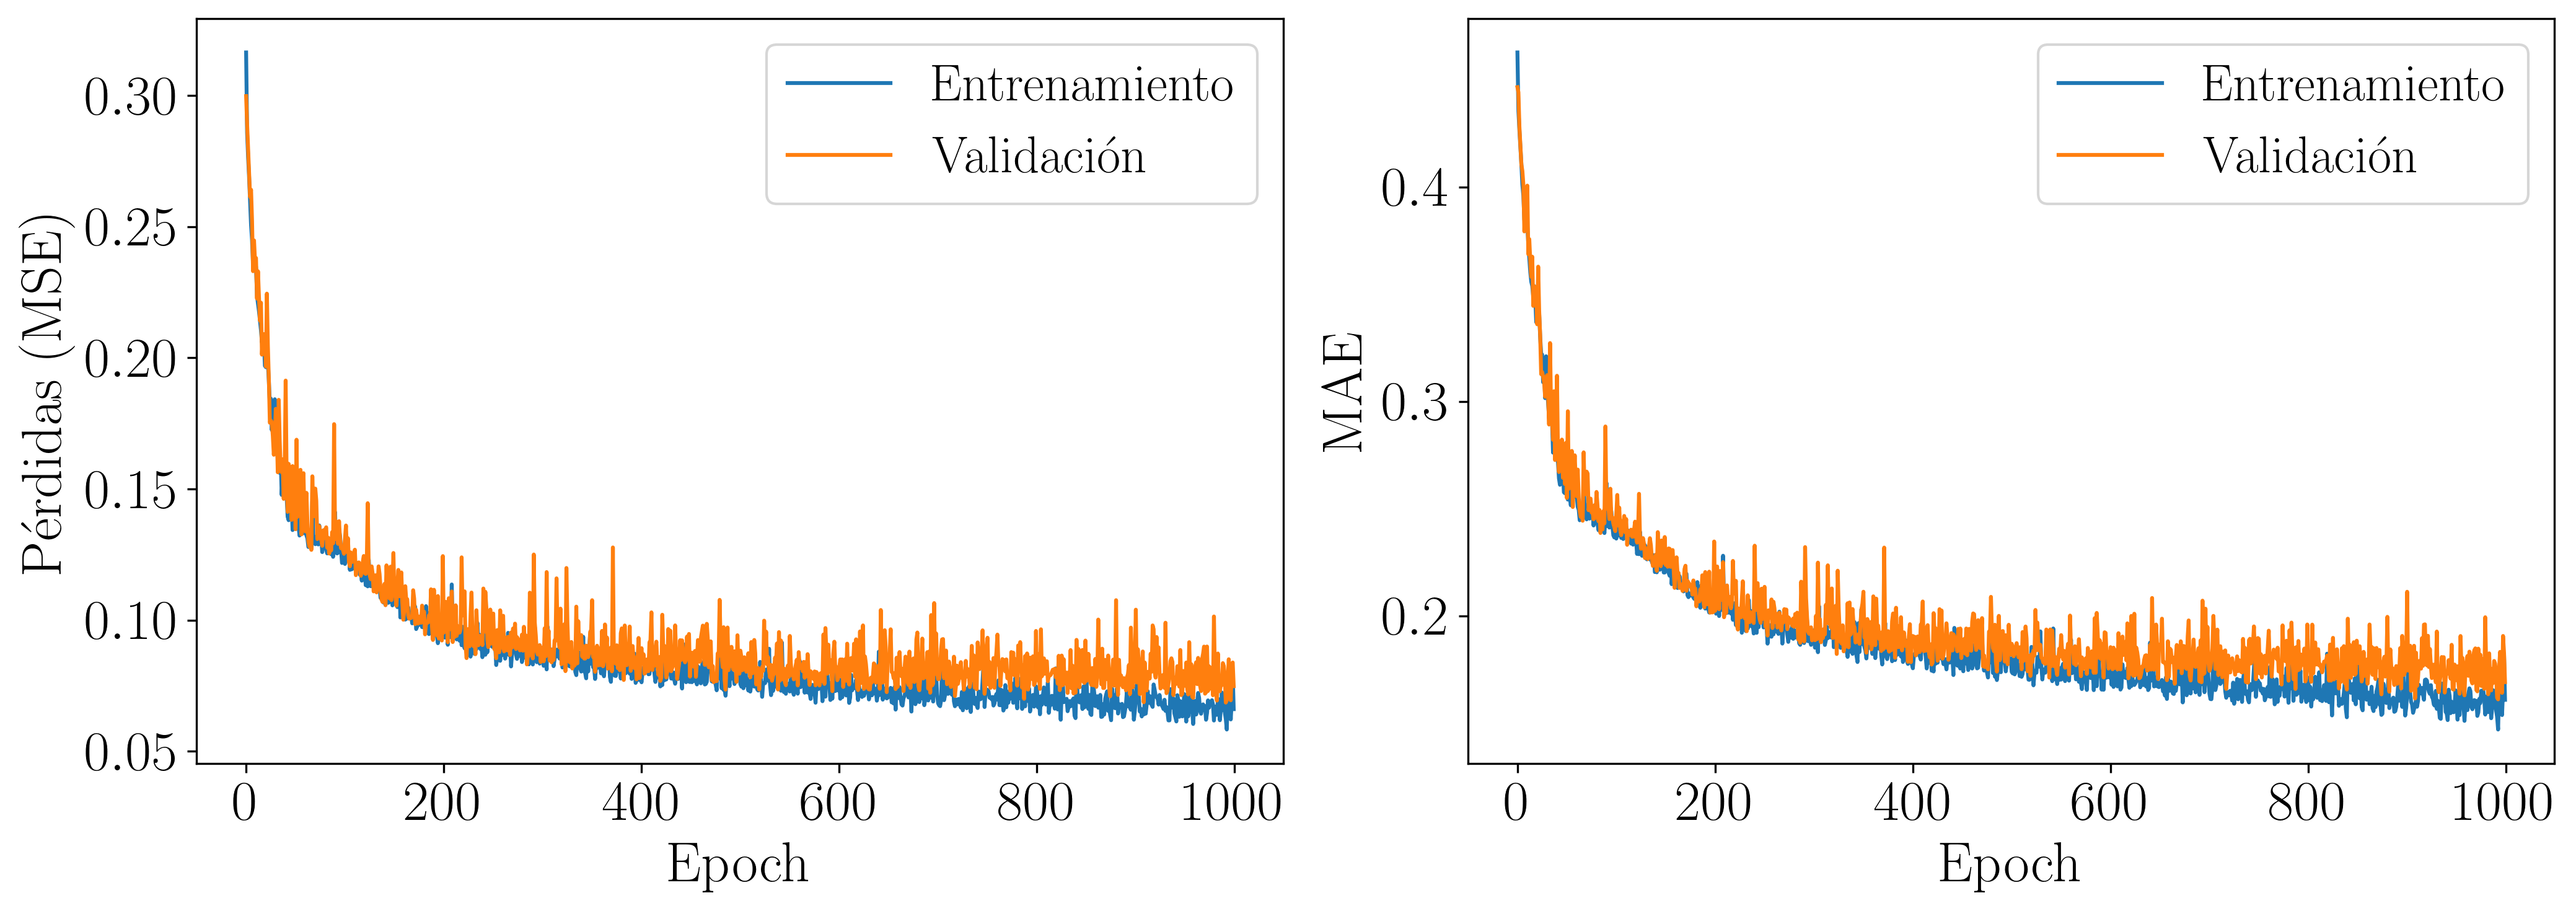

In [43]:
# Cargar el history desde el archivo .pkl
with open('model_history.pkl', 'rb') as file:
    history = pickle.load(file)

# Crear una figura con dos subgráficos en una fila
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Primer subgráfico: Pérdida de entrenamiento y validación
ax1.plot(history['loss'], label='Entrenamiento')
ax1.plot(history['val_loss'], label='Validación')
ax1.set_ylabel('Pérdidas (MSE)')
ax1.set_xlabel('Epoch')
ax1.legend()

# Segundo subgráfico: MAE de entrenamiento y validación
ax2.plot(history['mean_absolute_error'], label='Entrenamiento')
ax2.plot(history['val_mean_absolute_error'], label='Validación')
ax2.set_ylabel('MAE')
ax2.set_xlabel('Epoch')
ax2.legend()

# Mostrar la figura con los subgráficos
plt.tight_layout()
plt.show()